In [1]:
DATA_PATH='/content/drive/MyDrive/data'

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import os
import cv2

In [33]:
CATEGORIES = os.listdir(DATA_PATH)
CATEGORIES

['without_mask', 'with_mask']

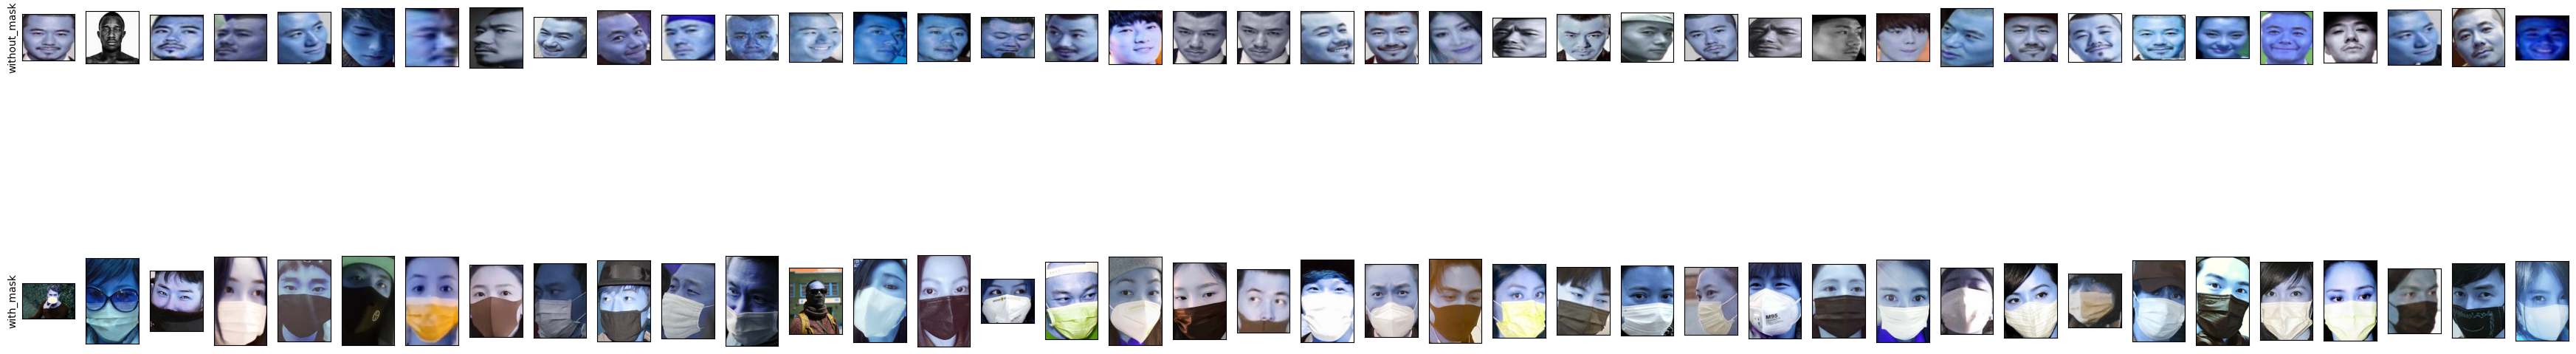

In [13]:
plt.figure(figsize=(35,10))
i=0
for c in CATEGORIES:
    path = os.path.join(DATA_PATH,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(2,40,i+1)
        plt.imshow(img_array)
        if i%40 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%40 == 0:
            break

plt.tight_layout()
plt.show()

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

In [39]:
TRAIN_DATA = []
img_size = 128

for j, c in enumerate(CATEGORIES):
    path = os.path.join(DATA_PATH, c)
    label = j
    for i in tqdm(os.listdir(path)):
        img = cv2.imread(os.path.join(path, i))
        img = cv2.resize(img, (img_size, img_size))
        TRAIN_DATA.append([img, j])

print(len(TRAIN_DATA))


100%|██████████| 40/40 [00:00<00:00, 128.76it/s]

80


In [40]:
train_imgs=[]
train_labels=[]
for img, label in TRAIN_DATA:
  train_imgs.append(img)
  train_labels.append(label)

In [43]:
train_imgs_np=np.array(train_imgs)
train_labels_np=np.array(train_labels)
print(train_imgs_np.shape, train_labels_np.shape)

(80, 128, 128, 3) (80,)


In [46]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=(img_size,img_size,3)),

    ## hidden layers
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'), # input->(32,32) output->(28,28)
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    ## output layer
    layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [47]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [49]:
h = model.fit(x=train_imgs_np, y=train_labels_np, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
2/2 [==============================] - 5s 1s/step - loss: 400.4681 - accuracy: 0.4844 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
2/2 [==============================] - 2s 932ms/step - loss: 98.5488 - accuracy: 0.4531 - val_loss: 95.4942 - val_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 2s 912ms/step - loss: 21.1626 - accuracy: 0.6406 - val_loss: 1.0431e-07 - val_accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 2s 914ms/step - loss: 12.3953 - accuracy: 0.3906 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 2s 958ms/step - loss: 3.0278 - accuracy: 0.5000 - val_loss: 6.2720 - val_accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 2s 905ms/step - loss: 1.2064 - accuracy: 0.7188 - val_loss: 0.1351 - val_accuracy: 0.9375
Epoch 7/10
2/2 [==============================] - 3s 2s/step - loss: 1.0505 - accuracy: 0.6875 - val_loss: 1.6305 - val_accuracy: 0.2500
Epoc

In [52]:
# Save the trained model
model.save('mask_detection_model.h5')
model = keras.models.load_model('mask_detection_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
# webcam
def detect_mask():
    cap = cv2.VideoCapture(0)  # Use 0 for the default webcam

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        # Preprocess the frame
        resized_frame = cv2.resize(frame, (img_size, img_size))
        normalized_frame = resized_frame / 255.0  # Normalize pixel values
        input_data = np.expand_dims(normalized_frame, axis=0)

        # Predict using the loaded model
        prediction = model.predict(input_data)

        # Get the label with the highest probability
        predicted_label = np.argmax(prediction)

        # Display the result on the frame
        label = "With Mask" if predicted_label == 1 else "Without Mask"
        cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Display the frame
        cv2.imshow('Mask Detection', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Run mask detection on webcam
detect_mask()

Failed to grab frame
